In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 12 16:02:14 2023

@author: konstantinos, paola 

Calculate the luminosity normalized that we will use in the blue (BB) curve.

NOTES FOR OTHERS:
- All the functions have to be applied to a CELL
- arguments are in cgs, NOT in log.
- make changes in VARIABLES: frequencies range, fixes (number of snapshots) anf thus days
"""

# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt

# Chocolate imports
from src.Luminosity.photosphere import get_photosphere
from src.Optical_Depth.opacity_table import opacity

# Constants
c = 2.9979e10 #[cm/s]
h = 6.6261e-27 #[gcm^2/s]
Kb = 1.3806e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10

###
##
# VARIABLES
##
###

# Frequencies [Hz]
n_min = 1e12 
n_max = 1e18
n_spacing = 10000
n_array = np.linspace(n_min, n_max, num = n_spacing)
n_logspace = np.log10(n_array)
# n_logspace = np.linspace(np.log10(n_min), np.log10(n_max), num = n_spacing)

# Snapshots
fixes4 = [177]
fixes4.append(np.arange(233,264))
days4 = [0.5, 1.015, 1.025, 1.0325, 1.0435, 1.0525, 1.06, 1.07, 1.08, 1.0875, 1.0975, 1.1075, 1.115, 1.125, 1.135, 1.1425, 1.1525, 1.1625, 1.17, 1.18, 1.19, 1.1975, 1.2075, 1.2175, 1.2275, 1.235, 1.245, 1.255, 1.2625, 1.2725, 1.2825, 1.29] #t/t_fb
fixes6 = [844, 881, 898, 925, 950, 1006]
days6 = [1.00325, 1.13975, 1,2025, 1.302, 1.39425, 1.60075] #t/t_fb

###
##
# FUNCTIONS
##
###

def emissivity(Temperature, Density, cell_vol):
    """ Gives emissivity in a cell. """
    k_planck = opacity(Temperature, Density, 'planck', ln = False)
    emiss = alpha * c * Temperature**4 * k_planck * cell_vol
    return emiss

def find_peak(Temperature):
    """Find the frequency of the peak with Wien law."""
    # Wien law
    const_npeak = 5.879e10 # [Hz/K]
    npeak = const_npeak * Temperature
    return npeak 

def planck_fun_n_cell(Temperature: float, n: float) -> float:
    """ Planck function in a cell. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)
    return fun

In [2]:
print(n_logspace)

[12.         14.00436395 14.30323884 ... 17.99991312 17.99995656
 18.        ]


5.879e+16


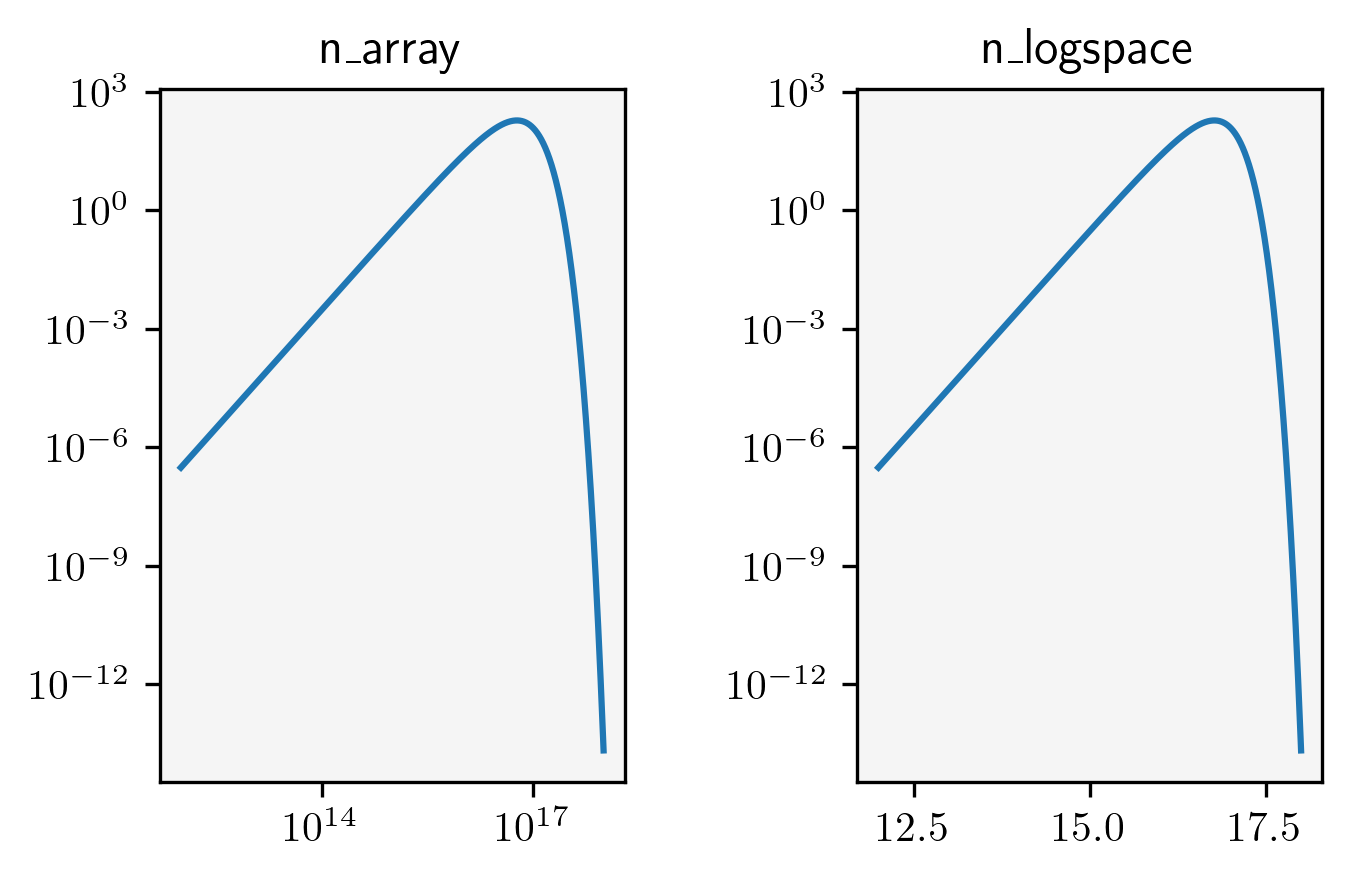

In [3]:
# Check how plots look: use n_array AND THEN LOGLOG

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace = 0.5)
axs[0].plot(n_array, planck_fun_n_cell(1e6, n_array))
axs[0].set_title('n_array')
axs[0].loglog()
axs[1].plot(n_logspace, planck_fun_n_cell(1e6, n_array))
axs[1].set_title('n_logspace')
axs[1].set_yscale('log')

print(find_peak(1e6))

In [4]:
def planck_fun_cell(Temperature: float) -> float:
    """
    Bolometric planck function in a cell: B(T).
    """
    n_Bn_array = []
    
    for n in n_array:
        n_Bn = planck_fun_n_cell(Temperature, n)
        n_Bn_array.append(n_Bn)
        
    # Integrate
    n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
    fun = np.trapz(n_Bn_array, n_array)
    return fun

c = planck_fun_cell(1e6)
print(c)

1.804685220280232e+19


In [5]:
# def old_planck_fun_cell(Temperature: float) -> float:
#     """
#     Bolometric planck function in a cell: B(T).
#     """
#     n_Bn_array = []
    
#     for n in n_array:
#         n_Bn = n * planck_fun_n_cell(Temperature, n)
#         n_Bn_array.append(n_Bn)
        
#     # Integrate
#     n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
#     fun = np.trapz(n_Bn_array, n_logspace)
#     return fun

In [6]:
# # Check the mess with integration of B: almost the same thus we don't have problem integrating beyond the peak
# def test_peak(Temperature: float) -> float:
#     """
#     Bolometric planck function in a cell: B(T).
#     """
#     n_Bn_array = []
#     peak = find_peak(Temperature)
    
#     for n in n_array:
#         if n > peak:
#             n_Bn = 0 
#         else:
#             n_Bn = n * old_planck_fun_n_cell(Temperature, n)
#         n_Bn_array.append(n_Bn)
        
#     # Integrate
#     n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
#     fun = np.trapz(n_Bn_array, n_logspace)
#     return fun

# a = old_planck_fun_cell(1e6)
# b = test_peak(1e6)
# print("B all frequencies: ", a)
# print("B cut at the peak: ", b)

In [7]:
# Is it correct to use n_logspace? Almost, but no because the interval don't match. We define our trapz
# def hand_integration(fun, arr):
#     """ Apply trapz rule on fun = f(arr) for not evenly space x"""
#     F = 0
    
#     for i in range(1,len(arr)):
#         delta_x = arr[i] - arr[i-1]
#         print(delta_x)
#         f_step = (fun[i] + fun[i-1]) * delta_x / 2
#         F += f_step
        
#     return F

# funct = n_array*planck_fun_n_cell(1e6, n_array)
# c = hand_integration(funct, n_logspace)
# print('B by hand: ', c)

In [8]:
def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n:int):
    """
    Temperature, Density and volume: np.array from near to the BH to far away. 
    Thus we will use negative index in the for loop.
    tau: np.array from outside to inside.
    n is the frequency.

    We obtain luminosity in a cell.
    """
    epsilon = emissivity(Temperature, Density, volume)
    lum_cell = epsilon * planck_fun_n_cell(Temperature, n) * np.exp(-tau)
    return (lum_cell/planck_fun_cell(Temperature))
    

In [9]:
def final_normalisation(L_array: np.array, luminosity_fld: float) -> float:
    """ Find the normalisation constant from FLD model for L_tilde_nu (which is a function of lenght = len(n_array)). """  
    n_L_array = n_array * L_array
    L = np.trapz(n_L_array, n_logspace)
    norm = luminosity_fld / L
    print('const normalisation: ', norm)
    return  norm

In [10]:
# MAIN
if __name__ == "__main__":
    m = 6
    fld_data = np.loadtxt('reddata_m'+ str(m) +'.txt')
    luminosity_fld_fix = fld_data[1]

    fix_index = 0
    rays_den, rays_T, rays_tau, photosphere, radii = get_photosphere(fixes6[fix_index], m)
    dr = (radii[1] - radii[0]) * Rsol_to_cm
    volume = 4 * np.pi * radii**2 * dr  / 192

    lum_n = np.zeros(len(n_logspace))
    for j in range(len(rays_den)):
        for i in range(len(rays_tau[j])):              
            T = rays_T[j][-i]
            rho = rays_den[j][-i] 
            opt_depth = rays_tau[j][i]
            cell_vol = volume[-i]

            # Ensure we can interpolate
            rho_low = np.exp(-22)
            T_low = np.exp(8.77)
            T_high = np.exp(17.8)
            if rho < rho_low or T < T_low or T > T_high:
                continue

            for n_index in range(len(n_array)):
                lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n_array[n_index])
                lum_n[n_index] += lum_n_cell
        
        print('ray:', j)

    # ANOTHER TRY TO NORMALISE
    const_norm = final_normalisation(lum_n, luminosity_fld_fix[fix_index])
    lum_tilde_n = lum_n *  const_norm

    check = np.trapz(n_array * lum_tilde_n, n_logspace)
    check="{:.2e}".format(check) #scientific notation
    print('bolometric L', check)

    # with open('Ltilda_m'+ str(m) + '.txt', 'a') as f:
    #     # f.write(' '.join(map(str, n_logspace)) + '\n')
    #     f.write('#snap '+ str(fixes4[fix_index])+'\n')
    #     f.write(' '.join(map(str, lum_tilde_n)) + '\n')
    #     f.close()


/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THE_SPHERICAL_CASTER'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/Calculators/spherical_caster.py", line 41:
@numba.njit
def THE_SPHERICAL_CASTER(radii, R,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THE_SPHERICAL_CASTER'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#depreca

Shape Ray: (192, 500)


/Users/paolamartire/tde_comparison/src/Luminosity/photosphere.py:61: RuntimeWarning: divide by zero encountered in log
  logT = np.log(T)
/Users/paolamartire/tde_comparison/src/Luminosity/photosphere.py:63: RuntimeWarning: divide by zero encountered in log
  logrho = np.log(rho)


ray: 0
ray: 1
ray: 2
ray: 3
ray: 4
ray: 5
ray: 6
ray: 7
ray: 8
ray: 9
ray: 10
ray: 11
ray: 12
ray: 13
ray: 14
ray: 15
ray: 16
ray: 17
ray: 18
ray: 19
ray: 20
ray: 21
ray: 22
ray: 23
ray: 24
ray: 25
ray: 26
ray: 27
ray: 28
ray: 29
ray: 30
ray: 31
ray: 32
ray: 33
ray: 34
ray: 35
ray: 36
ray: 37
ray: 38
ray: 39
ray: 40
ray: 41
ray: 42
ray: 43
ray: 44
ray: 45
ray: 46
ray: 47
ray: 48
ray: 49
ray: 50
ray: 51
ray: 52
ray: 53
ray: 54
ray: 55
ray: 56
ray: 57
ray: 58
ray: 59
ray: 60
ray: 61
ray: 62
ray: 63
ray: 64
ray: 65
ray: 66
ray: 67
ray: 68
ray: 69
ray: 70
ray: 71


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_69427/2284939216.py:74: RuntimeWarning: overflow encountered in exp
  fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)


ray: 72
ray: 73
ray: 74
ray: 75
ray: 76
ray: 77
ray: 78
ray: 79
ray: 80
ray: 81
ray: 82
ray: 83
ray: 84
ray: 85
ray: 86
ray: 87
ray: 88
ray: 89
ray: 90
ray: 91
ray: 92
ray: 93
ray: 94
ray: 95
ray: 96
ray: 97
ray: 98
ray: 99
ray: 100
ray: 101
ray: 102
ray: 103


KeyboardInterrupt: 

In [ ]:
v3 = n_array**3

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_array, lum_tilde_n)
ax.plot(n_array, v3, label = '$\nu^3')
plt.xlabel(r'$log\nu$ [Hz]')
plt.ylim(1e21, 1e50)
plt.loglog()
plt.ylabel(r'$log\tilde{L}_\nu$ [erg/s]')
plt.grid()
#plt.text(1e14, 1e39, r'$t/t_{fb}:$ ' + f'{days4[fix_index]}\n B: {check}')
plt.savefig('Ltilda_m' + str(m) + '_snap' + str(fixes4[fix_index]))
#plt.legend()
plt.show()
ax.axvline(15, color = 'tab:orange')
ax.axvline(17, color = 'tab:orange')
ax.axvspan(15, 17, alpha=0.5, color = 'tab:orange')


plt.figure()
plt.plot(n_array, n_array * lum_tilde_n)
plt.loglog()
plt.show()